In [1]:
!pip install geopandas pyproj rtree shapely fiona rasterio mpl_interactions selenium earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 19.7 MB/s eta 0:00:00


In [2]:
import folium
import time
import rasterio
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from selenium import webdriver
from PIL import Image
from shapely.geometry import mapping
from rasterio.features import rasterize
from rasterio.transform import from_bounds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General Case

In [ ]:
# Define the bounding box coordinates
lat_min, lat_max, lon_min, lon_max = 46.03820115033646, 46.059658724302835, 14.493150900299726, 14.524067643131692
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Calculate the center of the bounding box
lat_center = (lat_min + lat_max) / 2
lon_center = (lon_min + lon_max) / 2

# Create a folium map centered on the calculated center point
m = folium.Map(location=[lat_center, lon_center], tiles="OpenStreetMap")

# Set the map to fit within the bounding box
m.fit_bounds(bounds)

# Save the map as an HTML file
m.save("map.html")

# Set up Selenium WebDriver with headless Chrome options
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Open the HTML file and take a high-resolution screenshot
driver = webdriver.Chrome(options=options)
driver.set_window_size(4000, 4000)  # Set a large window size for high resolution
driver.get("file://" + "/content/map.html")
time.sleep(3)  # Wait for the map to load fully

# Save the screenshot as a PNG file
driver.save_screenshot("high_res_map_region.png")
driver.quit()

In [ ]:
# Define the bounding box coordinates
lat_min, lat_max, lon_min, lon_max = 46.03820115033646, 46.059658724302835, 14.493150900299726, 14.524067643131692
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Calculate the center of the bounding box
lat_center = (lat_min + lat_max) / 2
lon_center = (lon_min + lon_max) / 2

# Mapbox satellite tiles URL with your access token
access_token = 'pk.eyJ1IjoiaXNzZW1zYXRvIiwiYSI6ImNtM2l5OG5xNzA2cnIya3NlN2Fodzd4NWwifQ.3g96NlYH2koRGchHZ1_yGw'
tiles_url = f'https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={access_token}'

# Create a folium map centered on the calculated center point with Mapbox satellite tiles
m = folium.Map(
    location=[lat_center, lon_center],
    zoom_start=15,
    tiles=tiles_url,
    attr='Mapbox',
)

# Set the map to fit within the bounding box
m.fit_bounds(bounds)

# Save the map as an HTML file
m.save("map.html")

# Set up Selenium WebDriver with headless Chrome options
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Open the HTML file and take a high-resolution screenshot
driver = webdriver.Chrome(options=options)
driver.set_window_size(4000, 4000)  # Set a large window size for high resolution
driver.get("file://" + "/content/map.html")
time.sleep(3)  # Wait for the map to load fully

# Save the screenshot as a PNG file
driver.save_screenshot("high_res_satellite_region.png")
driver.quit()


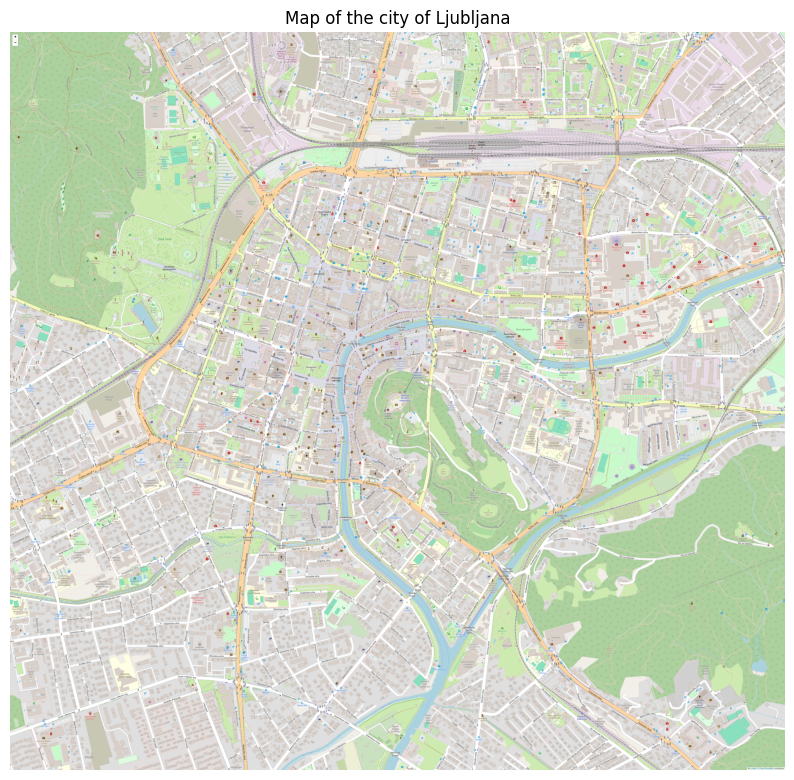

In [ ]:
immage_ljubljana_path = "high_res_map_region.png"

# Load the mask image (adjust path as necessary)
mask = Image.open(immage_ljubljana_path)

# Display the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Map of the city of Ljubljana")
plt.axis('off')
plt.show()

In [ ]:
immage_ljubljana_path = "high_res_satellite_region.png"

# Load the mask image (adjust path as necessary)
mask = Image.open(immage_ljubljana_path)

# Display the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Map of the city of Ljubljana")
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Now we need to calculate all the necessary longitude and latitute so that we can gather the data correctly. The issue is that the maximum distance accettible to gather individually is 0.009 so the distance among the bounds have to be smaller than that value and for this reason we have to compute them individually

In [ ]:
def create_grid_boxes(bounds, num_rows, num_cols):
    """
    Divide the bounding box into a grid of sub-boxes.

    Parameters:
        bounds (tuple): Bounding box as (min_lon, min_lat, max_lon, max_lat).
        num_rows (int): Number of rows to divide the bounding box into.
        num_cols (int): Number of columns to divide the bounding box into.

    Returns:
        dict: A dictionary where each key is a box identifier and the value is a tuple
              representing the bounding coordinates (min_lon, min_lat, max_lon, max_lat).
    """
    min_lon, min_lat, max_lon, max_lat = bounds
    distance_lat = max_lat - min_lat  # Total latitude distance
    distance_lon = max_lon - min_lon  # Total longitude distance
    print ()

    # Calculate the size of each sub-box
    bounding_lat = distance_lat / num_rows
    bounding_lon = distance_lon / num_cols

    # Verify that the bounding_lat and bounding_lon values are reasonable
    print("Bounds =", bounds)
    print("distance_lat =", distance_lat)
    print("distance_lon =", distance_lon)
    print("bounding_lat =", bounding_lat, "; this value has to be smaller than 0.01")
    print("bounding_lon =", bounding_lon, "; this value has to be smaller than 0.01")

    # Create the grid of boxes
    grid_boxes = {}
    print ("Those are the values to take the data from OpenStreetMap")
    for row in range(num_rows):
        for col in range(num_cols):
            # Calculate boundaries for each box
            min_box_lat = min_lat + row * bounding_lat
            max_box_lat = min_box_lat + bounding_lat
            min_box_lon = min_lon + col * bounding_lon
            max_box_lon = min_box_lon + bounding_lon

            # Store each box with a unique key based on row and column
            box_key = f"_{row}{col}_box"
            grid_boxes[box_key] = (min_box_lon, max_box_lon,min_box_lat, max_box_lat)
            print(f"{box_key}: {grid_boxes[box_key]}")

    return grid_boxes

# Usage example
bounds = (14.493150900299726, 46.03820115033646, 14.524067643131692, 46.059658724302835)
num_rows = 3
num_cols = 4
grid_boxes = create_grid_boxes(bounds, num_rows, num_cols)


Bounds = (14.493150900299726, 46.03820115033646, 14.524067643131692, 46.059658724302835)
distance_lat = 0.021457573966372934
distance_lon = 0.030916742831966104
bounding_lat = 0.007152524655457644 ; this value has to be smaller than 0.01
bounding_lon = 0.007729185707991526 ; this value has to be smaller than 0.01
Those are the values to take the data from OpenStreetMap
_00_box: (14.493150900299726, 14.500880086007719, 46.03820115033646, 46.04535367499192)
_01_box: (14.500880086007719, 14.50860927171571, 46.03820115033646, 46.04535367499192)
_02_box: (14.50860927171571, 14.5163384574237, 46.03820115033646, 46.04535367499192)
_03_box: (14.5163384574237, 14.52406764313169, 46.03820115033646, 46.04535367499192)
_10_box: (14.493150900299726, 14.500880086007719, 46.04535367499192, 46.05250619964738)
_11_box: (14.500880086007719, 14.50860927171571, 46.04535367499192, 46.05250619964738)
_12_box: (14.50860927171571, 14.5163384574237, 46.04535367499192, 46.05250619964738)
_13_box: (14.516338457

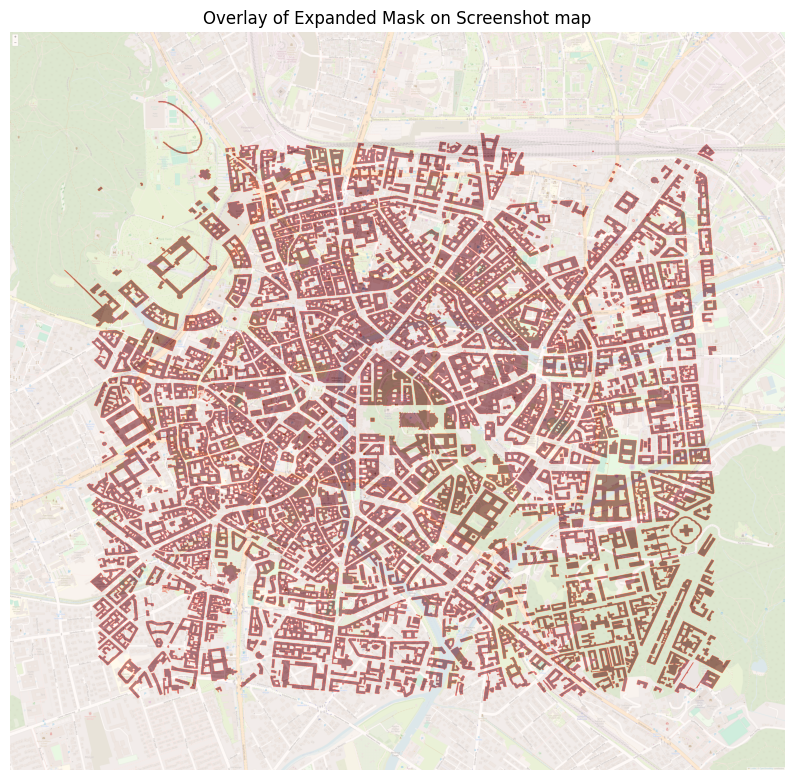

In [ ]:
# Load the GeoJSON file
gdf = gpd.read_file('/content/drive/My Drive/ComputerVisionProject_Group_Due/map.geojson')

# Ensure the CRS is WGS84 (EPSG:4326)
gdf = gdf.set_crs("EPSG:4326")

# Filter only for buildings or structures
if 'building' in gdf.columns:
    gdf = gdf[gdf['building'].notnull()]

# Load the PNG screenshot for reference
png_image_path = "high_res_map_region.png"
screenshot_image = Image.open(png_image_path)
width, height = screenshot_image.size  # Dimensions of the screenshot

# Get the bounding box of the filtered GeoDataFrame and apply a buffer
buffer_amount = 0.00275  # Adjust this value to increase(-) or decrease(+) the mask size 0.01 0.001
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
expanded_bounds = (
    bounds[0] - buffer_amount,  # minx - buffer
    bounds[1] - buffer_amount,  # miny - buffer
    bounds[2] + buffer_amount,  # maxx + buffer
    bounds[3] + buffer_amount   # maxy + buffer
)

# Define translation offsets for horizontal and vertical movement
translate_x = 0.0000  # Adjust this to move the mask left (-) or right (+)
translate_y = 0.0000  # Adjust this to move the mask up (-) or down (+)

# Adjust the expanded bounds for horizontal and vertical translation
expanded_bounds = (
    expanded_bounds[0] + translate_x,  # Shift minx by translate_x
    expanded_bounds[1] + translate_y,  # Shift miny by translate_y
    expanded_bounds[2] + translate_x,  # Shift maxx by translate_x
    expanded_bounds[3] + translate_y   # Shift maxy by translate_y
)

# Define the affine transform for the rasterization with adjusted bounds
transform = from_bounds(*expanded_bounds, width=width, height=height)

# Define shapes for rasterization: marking buildings as 1
shapes = ((geom, 1) for geom in gdf.geometry)

# Rasterize the GeoJSON data to create a binary mask
mask = rasterize(
    shapes,
    out_shape=(height, width),  # Match screenshot dimensions
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Resize the mask to exactly match the screenshot dimensions if there is a slight difference
mask_resized = np.array(Image.fromarray(mask).resize((width, height), Image.BILINEAR))

# Save the resized mask for verification
mask_image = Image.fromarray(mask_resized * 255)  # Scale binary mask to [0, 255] for saving as an image
mask_image_path = 'expanded_aligned_mask.png'
mask_image.save(mask_image_path)

# Convert the screenshot to an array for overlay
screenshot_array = np.array(screenshot_image)

# Plot the screenshot and the resized mask overlay
plt.figure(figsize=(10, 10))
plt.imshow(screenshot_array, alpha=0.8)  # Display the screenshot
plt.imshow(mask_resized, cmap="Reds", alpha=0.5)  # Overlay the resized mask in red
plt.title("Overlay of Expanded Mask on Screenshot map")
plt.axis("off")
plt.show()

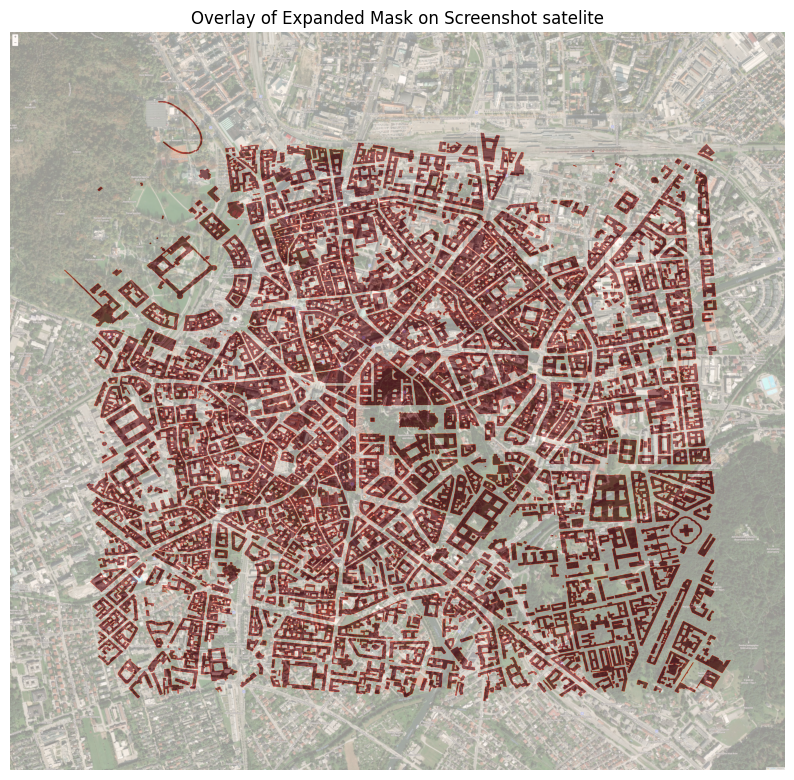

In [ ]:
# Load the GeoJSON file
gdf = gpd.read_file('/content/drive/My Drive/ComputerVisionProject_Group_Due/map.geojson')

# Ensure the CRS is WGS84 (EPSG:4326)
gdf = gdf.set_crs("EPSG:4326")

# Filter only for buildings or structures
if 'building' in gdf.columns:
    gdf = gdf[gdf['building'].notnull()]

# Load the PNG screenshot for reference
png_image_path = "high_res_satellite_region.png"
screenshot_image = Image.open(png_image_path)
width, height = screenshot_image.size  # Dimensions of the screenshot

# Get the bounding box of the filtered GeoDataFrame and apply a buffer
buffer_amount = 0.00275  # Adjust this value to increase(-) or decrease(+) the mask size 0.01 0.001
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
expanded_bounds = (
    bounds[0] - buffer_amount,  # minx - buffer
    bounds[1] - buffer_amount,  # miny - buffer
    bounds[2] + buffer_amount,  # maxx + buffer
    bounds[3] + buffer_amount   # maxy + buffer
)

# Define translation offsets for horizontal and vertical movement
translate_x = 0.0000  # Adjust this to move the mask left (-) or right (+)
translate_y = 0.0000  # Adjust this to move the mask up (-) or down (+)

# Adjust the expanded bounds for horizontal and vertical translation
expanded_bounds = (
    expanded_bounds[0] + translate_x,  # Shift minx by translate_x
    expanded_bounds[1] + translate_y,  # Shift miny by translate_y
    expanded_bounds[2] + translate_x,  # Shift maxx by translate_x
    expanded_bounds[3] + translate_y   # Shift maxy by translate_y
)

# Define the affine transform for the rasterization with adjusted bounds
transform = from_bounds(*expanded_bounds, width=width, height=height)

# Define shapes for rasterization: marking buildings as 1
shapes = ((geom, 1) for geom in gdf.geometry)

# Rasterize the GeoJSON data to create a binary mask
mask = rasterize(
    shapes,
    out_shape=(height, width),  # Match screenshot dimensions
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Resize the mask to exactly match the screenshot dimensions if there is a slight difference
mask_resized = np.array(Image.fromarray(mask).resize((width, height), Image.BILINEAR))

# Save the resized mask for verification
mask_image = Image.fromarray(mask_resized * 255)  # Scale binary mask to [0, 255] for saving as an image
mask_image_path = 'expanded_aligned_mask.png'
mask_image.save(mask_image_path)

# Convert the screenshot to an array for overlay
screenshot_array = np.array(screenshot_image)

# Plot the screenshot and the resized mask overlay
plt.figure(figsize=(10, 10))
plt.imshow(screenshot_array, alpha=0.8)  # Display the screenshot
plt.imshow(mask_resized, cmap="Reds", alpha=0.5)  # Overlay the resized mask in red
plt.title("Overlay of Expanded Mask on Screenshot satelite")
plt.axis("off")
plt.show()